In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/xview_recognition.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: xview_train/Shipping container/778dd2fe-ad63-4889-9380-8a7acba75977.tif  
  inflating: xview_train/Shipping container/7535dd1d-92f1-4007-8264-a6750c99a899.tif  
  inflating: xview_train/Shipping container/199e85aa-99c7-470b-9066-073634f2e02c.tif  
  inflating: xview_train/Shipping container/a4d2949f-f9f3-4fd3-ace0-4af8400bfd4a.tif  
  inflating: xview_train/Shipping container/44430654-4ec0-4f66-b6fa-86448807b011.tif  
  inflating: xview_train/Shipping container/ce8e443f-b915-486e-af5c-13e5f2ebb9f1.tif  
  inflating: xview_train/Shipping container/1ae7c2a0-63ee-46d4-acaa-b86d3af581b8.tif  
  inflating: xview_train/Shipping container/6efd49ec-7789-483c-93d5-90fe2d5098b0.tif  
  inflating: xview_train/Shipping container/cf285f00-3242-4259-895b-2da7282c0aaa.tif  
  inflating: xview_train/Shipping container/6d96f2ec-ed73-4639-abe7-53485b52db05.tif  
  inflating: xview_train/Shipping container/c7fc8511-d3a7-4ae9-bc6d-4

In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [5]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 47.9 MB/s eta 0:00:00


In [6]:
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=True, gen=True):
      data_gen = ImageDataGenerator(
             rotation_range=30,
             width_shift_range=0.1,
             height_shift_range=0.1,
             horizontal_flip=True,
             shear_range=0.2,
             zoom_range=0.1,
             brightness_range=[0.5, 1.5],
             fill_mode='nearest',
             cval=0.0,
             vertical_flip=True,
             rescale=1./255,
             data_format='channels_last',
             validation_split=0.2,
             interpolation_order=2,
      )
      while gen:
          if do_shuffle:
              np.random.shuffle(objs)
          groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
          for group in groups:
              images, labels = [], []
              for (filename, obj) in group:
                  if obj.category == "Helicopter":
                    img = load_geoimage(filename)
                    img = data_gen.random_transform(img)
                    images.append(img)
                    probabilities = np.zeros(len(categories))
                    probabilities[list(categories.values()).index(obj.category)] = 1
                    labels.append(probabilities)
                  else:
                    # If the object does not belong to the class "helicopter",
                    # append the original image without augmentation
                    img = load_geoimage(filename)
                    images.append(img)
                    probabilities = np.zeros(len(categories))
                    probabilities[list(categories.values()).index(obj.category)] = 1
                    labels.append(probabilities)
              images = np.array(images).astype(np.float32)
              labels = np.array(labels).astype(np.float32)
              yield images, labels

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [8]:
import json
# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [9]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [10]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)


In [11]:
# Load architecture
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model


def create_model(n_neurons):
    print('Load model')
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional base
    base_model.trainable = False

    # Create a new model on top of the pre-trained base
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = LeakyReLU(alpha=0.1)(x)  # Using Leaky ReLU activation function
    x = Dropout(0.5)(x)  # Adding dropout for regularization

    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = LeakyReLU(alpha=0.1)(x)  # Using Leaky ReLU activation function
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    outputs = Dense(n_neurons, activation='softmax')(x)

    # Compile the model
    model = Model(inputs, outputs)


    # Print model summary
    model.summary()

    opt = Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
import math
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 128
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

epochs = 30
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)



In [13]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [14]:
model = create_model(12)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Load model
27018416/27018416 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 148s 794ms/step - loss: 3.0140 - accuracy: 0.3960 - val_loss: 2.3734 - val_accuracy: 0.6048 - lr: 1.0000e-04
Epoch 2/30
151/151 [==============================] - ETA: 0s - loss: 2.3823 - accuracy: 0.5657
Epoch 2: val_accuracy improved from 0.60477 to 0.66277, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 111s 737ms/step - loss: 2.3823 - accuracy: 0.5657 - val_loss: 2.0632 - val_accuracy: 0.6628 - lr: 1.0000e-04
Epoch 3/30
151/151 [==============================] - ETA: 0s - loss: 2.2062 - accuracy: 0.6112
Epoch 3: val_accuracy improved from 0.66277 to 0.68896, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 110s 731ms/step - loss: 2.2062 - accuracy: 0.6112 - val_loss: 1.9498 - val_accuracy: 0.6890 - lr: 1.0000e-04
Epoch 4/30
151/151 [==============================] - ETA: 0s - loss: 2.0961 - accuracy: 0.6371
Epoch 4: val_accuracy improved from 0.68896 to 0.69925, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 711ms/step - loss: 2.0961 - accuracy: 0.6371 - val_loss: 1.8781 - val_accuracy: 0.6993 - lr: 1.0000e-04
Epoch 5/30
151/151 [==============================] - ETA: 0s - loss: 2.0038 - accuracy: 0.6592
Epoch 5: val_accuracy improved from 0.69925 to 0.70907, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 100s 664ms/step - loss: 2.0038 - accuracy: 0.6592 - val_loss: 1.8211 - val_accuracy: 0.7091 - lr: 1.0000e-04
Epoch 6/30
151/151 [==============================] - ETA: 0s - loss: 1.9356 - accuracy: 0.6697
Epoch 6: val_accuracy improved from 0.70907 to 0.71796, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 713ms/step - loss: 1.9356 - accuracy: 0.6697 - val_loss: 1.7748 - val_accuracy: 0.7180 - lr: 1.0000e-04
Epoch 7/30
151/151 [==============================] - ETA: 0s - loss: 1.8801 - accuracy: 0.6780
Epoch 7: val_accuracy improved from 0.71796 to 0.71936, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 108s 714ms/step - loss: 1.8801 - accuracy: 0.6780 - val_loss: 1.7297 - val_accuracy: 0.7194 - lr: 1.0000e-04
Epoch 8/30
151/151 [==============================] - ETA: 0s - loss: 1.8249 - accuracy: 0.6887
Epoch 8: val_accuracy improved from 0.71936 to 0.72451, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 712ms/step - loss: 1.8249 - accuracy: 0.6887 - val_loss: 1.6901 - val_accuracy: 0.7245 - lr: 1.0000e-04
Epoch 9/30
151/151 [==============================] - ETA: 0s - loss: 1.7642 - accuracy: 0.6973
Epoch 9: val_accuracy improved from 0.72451 to 0.73012, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 712ms/step - loss: 1.7642 - accuracy: 0.6973 - val_loss: 1.6481 - val_accuracy: 0.7301 - lr: 1.0000e-04
Epoch 10/30
151/151 [==============================] - ETA: 0s - loss: 1.7206 - accuracy: 0.7078
Epoch 10: val_accuracy did not improve from 0.73012
151/151 [==============================] - 106s 707ms/step - loss: 1.7206 - accuracy: 0.7078 - val_loss: 1.6106 - val_accuracy: 0.7283 - lr: 1.0000e-04
Epoch 11/30
151/151 [==============================] - ETA: 0s - loss: 1.6781 - accuracy: 0.7102
Epoch 11: val_accuracy improved from 0.73012 to 0.73340, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 712ms/step - loss: 1.6781 - accuracy: 0.7102 - val_loss: 1.5792 - val_accuracy: 0.7334 - lr: 1.0000e-04
Epoch 12/30
151/151 [==============================] - ETA: 0s - loss: 1.6333 - accuracy: 0.7206
Epoch 12: val_accuracy improved from 0.73340 to 0.73854, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 712ms/step - loss: 1.6333 - accuracy: 0.7206 - val_loss: 1.5471 - val_accuracy: 0.7385 - lr: 1.0000e-04
Epoch 13/30
151/151 [==============================] - ETA: 0s - loss: 1.5837 - accuracy: 0.7281
Epoch 13: val_accuracy improved from 0.73854 to 0.73901, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 100s 664ms/step - loss: 1.5837 - accuracy: 0.7281 - val_loss: 1.5150 - val_accuracy: 0.7390 - lr: 1.0000e-04
Epoch 14/30
151/151 [==============================] - ETA: 0s - loss: 1.5532 - accuracy: 0.7297
Epoch 14: val_accuracy improved from 0.73901 to 0.74181, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 99s 660ms/step - loss: 1.5532 - accuracy: 0.7297 - val_loss: 1.4867 - val_accuracy: 0.7418 - lr: 1.0000e-04
Epoch 15/30
151/151 [==============================] - ETA: 0s - loss: 1.5107 - accuracy: 0.7406
Epoch 15: val_accuracy improved from 0.74181 to 0.74275, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 100s 663ms/step - loss: 1.5107 - accuracy: 0.7406 - val_loss: 1.4585 - val_accuracy: 0.7428 - lr: 1.0000e-04
Epoch 16/30
151/151 [==============================] - ETA: 0s - loss: 1.4742 - accuracy: 0.7431
Epoch 16: val_accuracy improved from 0.74275 to 0.74977, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 108s 716ms/step - loss: 1.4742 - accuracy: 0.7431 - val_loss: 1.4335 - val_accuracy: 0.7498 - lr: 1.0000e-04
Epoch 17/30
151/151 [==============================] - ETA: 0s - loss: 1.4321 - accuracy: 0.7470
Epoch 17: val_accuracy did not improve from 0.74977
151/151 [==============================] - 99s 660ms/step - loss: 1.4321 - accuracy: 0.7470 - val_loss: 1.4080 - val_accuracy: 0.7479 - lr: 1.0000e-04
Epoch 18/30
151/151 [==============================] - ETA: 0s - loss: 1.4095 - accuracy: 0.7519
Epoch 18: val_accuracy improved from 0.74977 to 0.75023, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 99s 660ms/step - loss: 1.4095 - accuracy: 0.7519 - val_loss: 1.3849 - val_accuracy: 0.7502 - lr: 1.0000e-04
Epoch 19/30
151/151 [==============================] - ETA: 0s - loss: 1.3707 - accuracy: 0.7555
Epoch 19: val_accuracy improved from 0.75023 to 0.75070, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 100s 663ms/step - loss: 1.3707 - accuracy: 0.7555 - val_loss: 1.3570 - val_accuracy: 0.7507 - lr: 1.0000e-04
Epoch 20/30
151/151 [==============================] - ETA: 0s - loss: 1.3444 - accuracy: 0.7597
Epoch 20: val_accuracy improved from 0.75070 to 0.75491, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 711ms/step - loss: 1.3444 - accuracy: 0.7597 - val_loss: 1.3383 - val_accuracy: 0.7549 - lr: 1.0000e-04
Epoch 21/30
151/151 [==============================] - ETA: 0s - loss: 1.3094 - accuracy: 0.7664
Epoch 21: val_accuracy did not improve from 0.75491
151/151 [==============================] - 99s 656ms/step - loss: 1.3094 - accuracy: 0.7664 - val_loss: 1.3171 - val_accuracy: 0.7549 - lr: 1.0000e-04
Epoch 22/30
151/151 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.7684
Epoch 22: val_accuracy improved from 0.75491 to 0.75538, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 100s 661ms/step - loss: 1.2869 - accuracy: 0.7684 - val_loss: 1.3074 - val_accuracy: 0.7554 - lr: 1.0000e-04
Epoch 23/30
151/151 [==============================] - ETA: 0s - loss: 1.2586 - accuracy: 0.7710
Epoch 23: val_accuracy did not improve from 0.75538
151/151 [==============================] - 106s 704ms/step - loss: 1.2586 - accuracy: 0.7710 - val_loss: 1.2827 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 24/30
151/151 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.7756
Epoch 24: val_accuracy improved from 0.75538 to 0.76146, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 107s 714ms/step - loss: 1.2290 - accuracy: 0.7756 - val_loss: 1.2600 - val_accuracy: 0.7615 - lr: 1.0000e-04
Epoch 25/30
151/151 [==============================] - ETA: 0s - loss: 1.2049 - accuracy: 0.7831
Epoch 25: val_accuracy did not improve from 0.76146
151/151 [==============================] - 99s 656ms/step - loss: 1.2049 - accuracy: 0.7831 - val_loss: 1.2430 - val_accuracy: 0.7554 - lr: 1.0000e-04
Epoch 26/30
151/151 [==============================] - ETA: 0s - loss: 1.1761 - accuracy: 0.7838
Epoch 26: val_accuracy did not improve from 0.76146
151/151 [==============================] - 100s 663ms/step - loss: 1.1761 - accuracy: 0.7838 - val_loss: 1.2297 - val_accuracy: 0.7605 - lr: 1.0000e-04
Epoch 27/30
151/151 [==============================] - ETA: 0s - loss: 1.1509 - accuracy: 0.7891
Epoch 27: val_accuracy did not improve from 0.76146
151/151 [==============================] - 106s 708ms/step - loss: 1.1509 - accuracy: 0.7891 - val

In [ ]:
# serialize model to JSON
model_json = model.to_json()
filepath = "/content/gdrive/MyDrive/Colab Notebooks/"
with open(filepath+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(filepath+"model.h5")
print("Saved model to disk")

KeyboardInterrupt: 

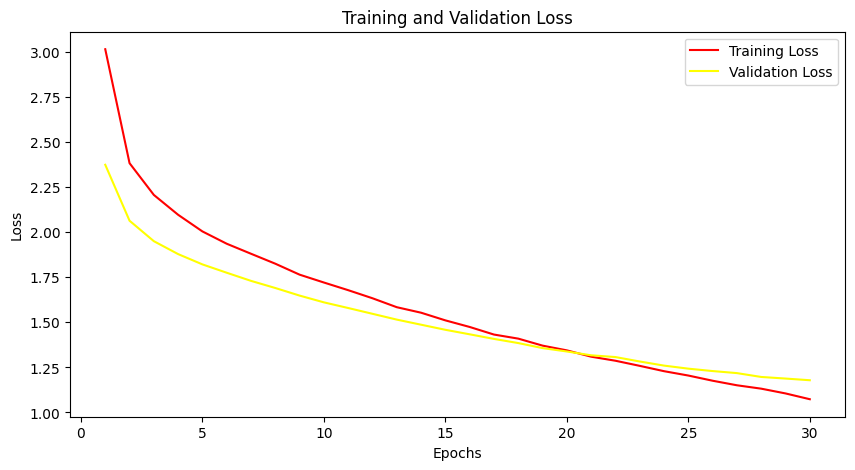

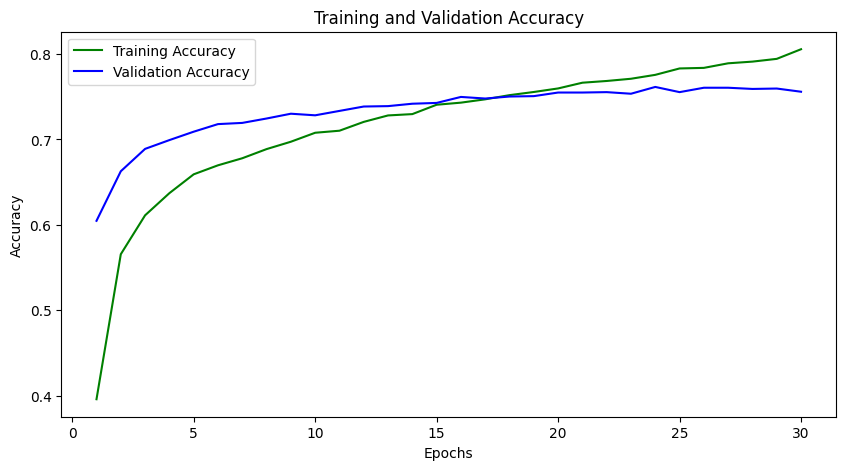

In [15]:
# Plotting
epochs_range = range(1, epochs+1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss', color='red')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [16]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [17]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [ ]:
from keras.models import model_from_json
filepath = "/content/gdrive/MyDrive/Colab Notebooks/"
# Load JSON model architecture
json_file = open(filepath + "model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [18]:
import numpy as np

# model.load_weights('model.keras')
y_true, y_pred = [], []
for index, ann in enumerate(anns):
    print(index)
    # Load image
    image = load_geoimage(ann.filename)
    for index, obj_pred in enumerate(ann.objects):
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 27ms/step
136
1/1 [==============================] - 0s 28ms/step
137
1/1 [==============================] - 0s 26ms/step
138
1/1 [==============================] - 0s 27ms/step
139
1/1 [==============================] - 0s 27ms/step
140
1/1 [==============================] - 0s 28ms/step
141
1/1 [==============================] - 0s 27ms/step
142
1/1 [==============================] - 0s 28ms/step
143
1/1 [==============================] - 0s 27ms/step
144
1/1 [==============================] - 0s 27ms/step
145
1/1 [==============================] - 0s 27ms/step
146
1/1 [==============================] - 0s 30ms/step
147
1/1 [==============================] - 0s 32ms/step
148
1/1 [==============================] - 0s 29ms/step
149
1/1 [==============================] - 0s 29ms/step
150
1/1 [==============================] - 0s 28ms/step
151
1/1 [==============================] - 0s 2

<ipython-input-7-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


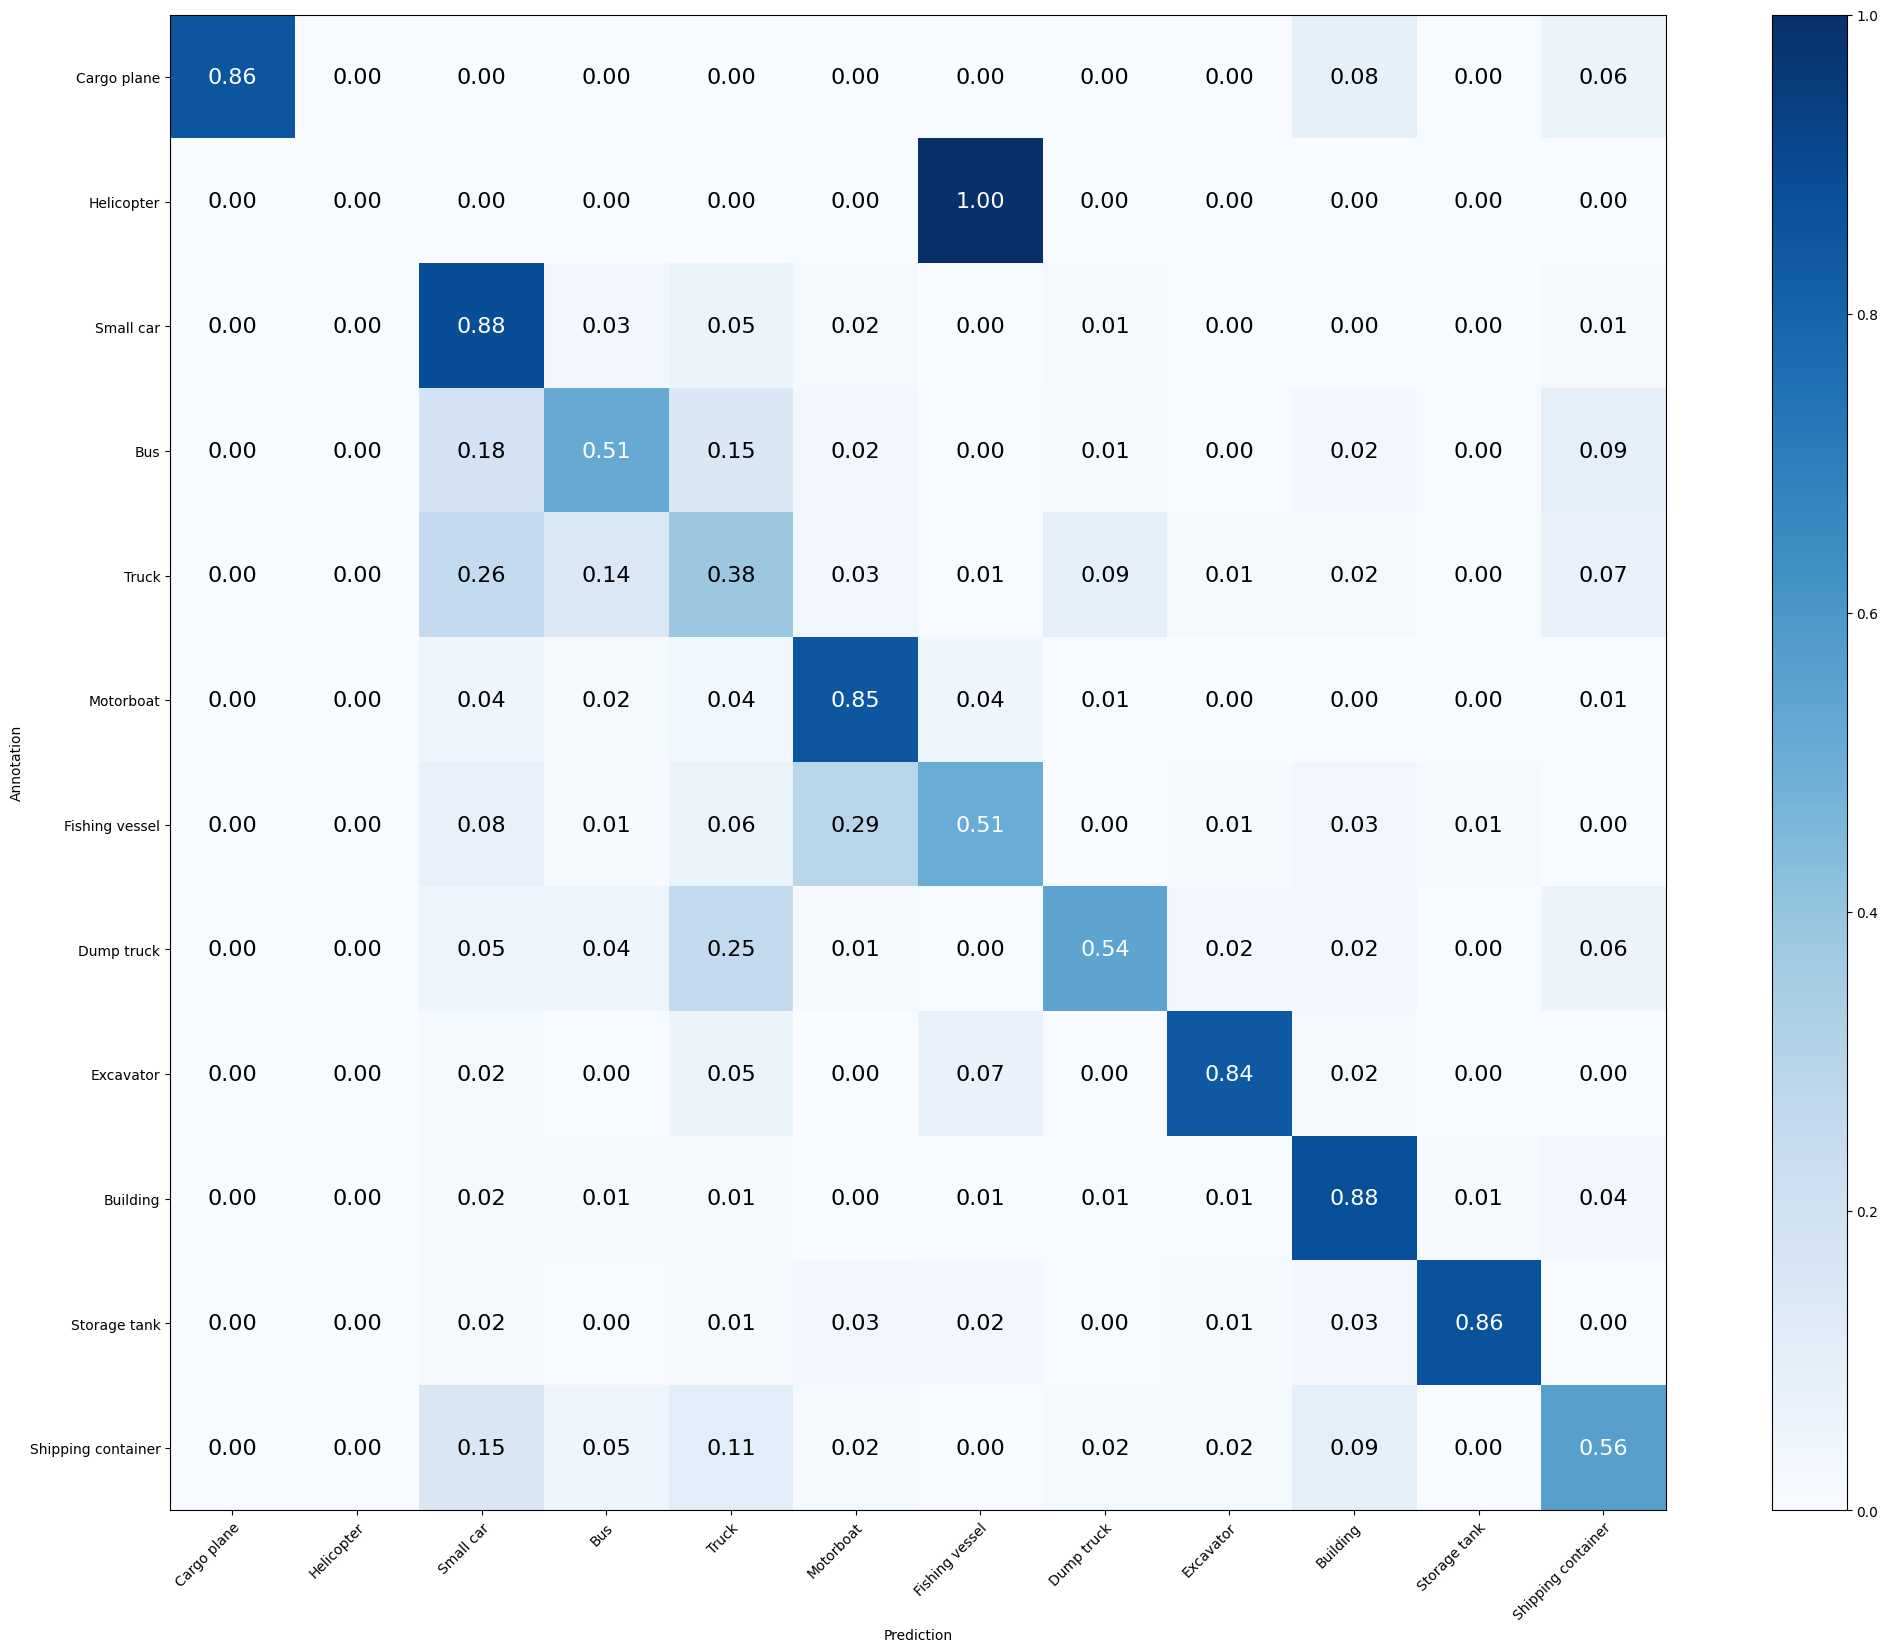

In [19]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [20]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 74.421%
Mean Recall: 63.956%
Mean Precision: 64.525%
> Cargo plane: Recall: 85.542% Precision: 97.260% Specificity: 99.922% Dice: 91.026%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 88.296% Precision: 70.608% Specificity: 91.667% Dice: 78.467%
> Bus: Recall: 51.240% Precision: 60.488% Specificity: 96.615% Dice: 55.481%
> Truck: Recall: 38.033% Precision: 47.154% Specificity: 94.421% Dice: 42.105%
> Motorboat: Recall: 85.025% Precision: 84.810% Specificity: 97.323% Dice: 84.918%
> Fishing vessel: Recall: 50.538% Precision: 58.750% Specificity: 98.702% Dice: 54.335%
> Dump truck: Recall: 54.098% Precision: 62.264% Specificity: 98.408% Dice: 57.895%
> Excavator: Recall: 84.211% Precision: 75.000% Specificity: 99.379% Dice: 79.339%
> Building: Recall: 88.007% Precision: 92.442% Specificity: 98.137% Dice: 90.170%
> Storage tank: Recall: 86.420% Precision: 94.170% Specificity: 99.457% Dice: 90.129%
> Shipping container